# DogFaceNet version 3

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

### Data pre-processing

In [2]:
PATH = '../data/dogfacenet/'
PATH_IMAGES = PATH + 'images/'
PATH_RESIZED = PATH + 'resized/'

# Size of the input image into the network
SIZE = (100,100,3)
TEST_SPLIT = 0.05
VALID_SPLIT = 0.1

In [3]:
filenames = os.listdir(PATH_RESIZED)

i = 0

# Remove unique examples
while i<len(filenames):
    files = os.listdir(PATH_RESIZED + filenames[i])
    if len(files)<=1:
        filenames = filenames[:i] + filenames[i+1:]
    else:
        i += 1

# Compute the number of images
nbof_images = 0
for i in range(0,len(filenames)):
    files = os.listdir(PATH_RESIZED + filenames[i])
    nbof_images += len(files)

print("Number of images: " + str(nbof_images))
    
w, h, c = SIZE

images = np.empty((nbof_images,w,h,c))
labels = np.empty(nbof_images, dtype=int)

label = 0

index = 0

# Load images into numpy arrays
for i in tqdm_notebook(range(len(filenames))):
    files = os.listdir(PATH_RESIZED + filenames[i])
    for file in files:
        labels[index] = label
        # Read image
        image = sk.io.imread(PATH_RESIZED + filenames[i] + '/' + file)

        # Add the image to the table
        images[index] = image
        
        index += 1
    label += 1

# Normalize images:
images /= 255.
assert len(labels)==len(images)

Number of images: 5503


HBox(children=(IntProgress(value=0, max=1476), HTML(value='')))

In [4]:
w, h, c = SIZE

nbof_test = int(len(images)*TEST_SPLIT)

images_test = images[-nbof_test:]
labels_test = labels[-nbof_test:]

nbof_valid = int(len(images)*VALID_SPLIT)

images_valid = images[-nbof_test-nbof_valid:-nbof_test]
labels_valid = labels[-nbof_test-nbof_valid:-nbof_test]

images_train = images[:-nbof_test-nbof_valid]
labels_train = labels[:-nbof_test-nbof_valid]

print("Total number of images: " + str(len(labels)))
print("Number of test images: " + str(len(labels_test)))
print("Number of validation images: " + str(len(labels_valid)))
print("Number of training images: " + str(len(labels_train)))
print("Number of classes in the training set: " + str(labels_train[-1] - labels_train[0]))


# Creates the pairs

nbof_pairs = (len(images_valid)//2)*2 # it has to be multiple of 2

print("Number of pairs: " + str(nbof_pairs))

pairs = np.empty((nbof_pairs,w,h,c))
issame = np.empty(nbof_pairs, dtype=int)
y_pairs = np.empty(nbof_pairs)

nbof_same = 0

for i in tqdm_notebook(range(0,nbof_pairs,2)):
    ## alea_issame will decide if the new pair will be a pair of same dog images or a pair of different
    alea_issame = np.random.rand()

    if alea_issame < 0.5: # Then it will be a pair of same dogs
        # we randomly choose a dog
        choice = np.random.randint(len(labels_valid))
        
        # we extract the images of this class
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice])])
        chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice])])
        
        while len(labels_valid[np.equal(labels_valid,labels_valid[choice])]) < 2:
            choice = np.random.randint(len(labels_valid))
            chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice])])
            chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice])])
            
        # we then randomly choose two pictures of this class
        choice1 = np.random.randint(len(chosen_images))
        pairs[i] = chosen_images[choice1]
        y_pairs[i] = chosen_labels[choice1]
        
        save = np.copy(chosen_images)
        chosen_images = chosen_images[:choice1] + chosen_images[choice1+1:]
        if len(chosen_images) == 0:
            print("Bug!")
            print(save)
        choice2 = np.random.randint(len(chosen_images))
        pairs[i+1] = chosen_images[choice2]
        y_pairs[i+1] = chosen_labels[choice2]
        
        issame[i] = issame[i+1] = 1
        
        nbof_same += 1
        
    else: # Then it will be a pair of different dogs
        # we randomly choose two dogs
        choice1 = np.random.randint(len(labels_valid))
        
        # we extract the images of the class
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice1])])
        chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice1])])
        
        # we choose an image of this class
        choice = np.random.randint(len(chosen_images))
        #print(choice)
        pairs[i] = chosen_images[choice]
        y_pairs[i] = chosen_labels[choice]
        
        choice2 = np.random.randint(len(labels_valid))
        
        # check if we have two different classes
        while labels_valid[choice2] == labels_valid[choice1]:
            choice2 = np.random.randint(len(labels_valid))
        
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice2])])
        chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice2])])
        
        # we choose an image of this class
        choice = np.random.randint(len(chosen_images))
        
        pairs[i+1] = chosen_images[choice]
        y_pairs[i+1] = chosen_labels[choice]
        
        issame[i] = issame[i+1] = 0

print("Number of same images: " + str(nbof_same))
print("Number of validation images: " + str(len(labels_valid)))

Total number of images: 5503
Number of test images: 275
Number of validation images: 550
Number of training images: 4678
Number of classes in the training set: 1282
Number of pairs: 550


HBox(children=(IntProgress(value=0, max=275), HTML(value='')))


Number of same images: 142
Number of validation images: 550


In [5]:
# check all the pairs
for i in range(0,len(y_pairs),2):
    if issame[i] == 0:
        if y_pairs[i]==y_pairs[i+1]:
            print(y_pairs[i],y_pairs[i+1],issame[i])
    if issame[i] == 1:
        if y_pairs[i]!=y_pairs[i+1]:
            print(y_pairs[i],y_pairs[i+1],issame[i])

[1 1 0 0 0 0 1 1 0 0]
[1351. 1351. 1374. 1390. 1299. 1412. 1434. 1434. 1448. 1442.]


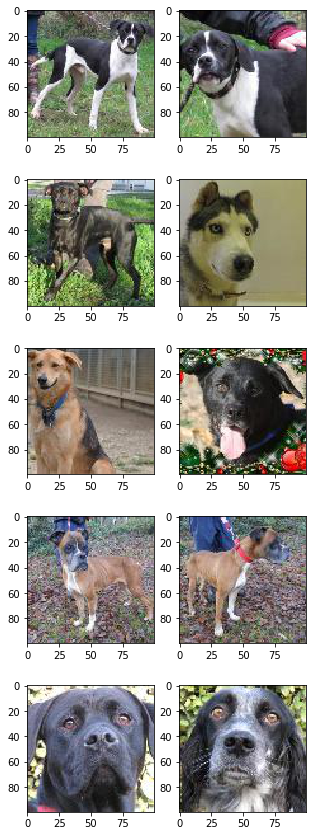

In [6]:
# check some pairs
s = 0
n = 5
print(issame[2*s:(n+s)*2])
print(y_pairs[2*s:(n+s)*2])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i])
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1])

In [7]:
labels_train = tf.keras.utils.to_categorical(labels_train)
labels_test = tf.keras.utils.to_categorical(labels_test)

y_pairs = tf.keras.utils.to_categorical(y_pairs)

print(labels_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### Loss and model definition

In [8]:
from tensorflow.keras import backend as K

m = 0.5
s = 64.
out_num = len(labels_train[0])

def cosineLoss(y_true,y_pred):
    # Compute the softmax like 
    s_cos = tf.multiply(y_pred, s)
    s_cos_m = tf.add(s_cos, -m)
    exp_s_cos = K.exp(s_cos)
    exp_s_cos_m = K.exp(s_cos_m)
    
    mask = tf.cast(y_true, tf.float32)
    m_mask = tf.multiply(mask,m)
    s_cos_m_mask = tf.subtract(s_cos, m_mask)
    den = K.sum(s_cos_m_mask,1)
    den_stacked = K.stack([den]*out_num,axis=-1)
    
    out = tf.divide(exp_s_cos_m,den_stacked)
    # Compute the categorical crossentropy
    return K.categorical_crossentropy(y_true,out)

#### Model number 1

In [27]:
def net(input_shape, emb_size=4):
    input_image = tf.keras.Input(input_shape,name='image_input')
    
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(input_image)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    emb = tf.keras.layers.Dense(32, activity_regularizer='l2')(x)
    
    out = tf.keras.layers.Dense(out_num, kernel_regularizer='l2', use_bias=False, name='output')(emb)
    model = tf.keras.Model(inputs=[input_image], outputs=out)
    return model

w, h, c = SIZE
input_shape = (w, h, c,)
model = net(input_shape)
model.compile(tf.keras.optimizers.Adam(),loss={'output':cosineLoss},metrics=['accuracy'])

#### Model number 2

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

Using TensorFlow backend.


In [10]:

images_train = preprocess_input(images_train)

In [11]:
pairs = preprocess_input(pairs)

In [12]:
w, h, c = SIZE
input_shape = (w, h, c,)

base_model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet', input_shape=input_shape)

for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
emb = tf.keras.layers.Dense(32, activity_regularizer='l2')(x)

out = tf.keras.layers.Dense(out_num, kernel_regularizer='l2', use_bias=False, name='output')(emb)

model = tf.keras.Model(inputs=base_model.input, outputs=out)
model.compile(tf.keras.optimizers.Adam(),loss={'output':cosineLoss},metrics=['accuracy'])
model.summary()

c:\users\guillaume\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 13, 13, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 13, 13, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 13, 13, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 7, 7, 256)    131328      activation_21[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 4, 4, 512)    2359808     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2b[0][0]              
__________

In [10]:
model = tf.keras.models.load_model('../output/model/resnet_' + str(40) + '.h5',custom_objects={'cosineLoss':cosineLoss})

### Train the model

In [17]:
model.save('../output/model/resnet.h5')

In [ ]:
count=40
filename='../output/model/resnet'
crt_filename = '../output/model/resnet.h5'
for i in range(1000):
    print("Beginning of epoch n°" + str(i))
    model.fit(
        [images_train],
        [labels_train],
        batch_size=128,
        epochs=4
        #validation_data=([labels_test],[y_test])
    )

    mod = tf.keras.Model(model.layers[0].input, model.layers[-2].output)
    predict=mod.predict(pairs)
    # Separates the pairs
    emb1 = predict[0::2]
    emb2 = predict[1::2]

    # Computes distance between pairs
    diff = np.square(emb1-emb2)
    dist = np.sum(diff,1)

    best = 0
    best_t = 0
    thresholds = np.arange(0,4,0.01)
    for i in range(len(thresholds)):
        less = np.less(dist, thresholds[i])
        acc = np.logical_not(np.logical_xor(less, issame[0::2]))
        acc = acc.astype(float)
        out = np.sum(acc)
        out = out/len(acc)
        if out > best:
            best_t = thresholds[i]
            best = out

    print("Best threshold: " + str(best_t))
    print("Best accuracy: " + str(best))
    
    count += 1
    if count%10==0:
        model.save('../output/model/resnet_' + str(count) + '.h5')
    

Beginning of epoch n°0
Epoch 1/4
4678/4678 [==============================] - ETA: 4:13 - loss: 8.2532 - acc: 0.007 - ETA: 2:10 - loss: 8.4236 - acc: 0.003 - ETA: 1:29 - loss: 8.2878 - acc: 0.005 - ETA: 1:08 - loss: 8.1750 - acc: 0.005 - ETA: 55s - loss: 8.1049 - acc: 0.004 - ETA: 47s - loss: 8.0540 - acc: 0.00 - ETA: 41s - loss: 8.0351 - acc: 0.00 - ETA: 36s - loss: 7.9765 - acc: 0.00 - ETA: 32s - loss: 7.9398 - acc: 0.00 - ETA: 29s - loss: 7.9102 - acc: 0.00 - ETA: 26s - loss: 7.8905 - acc: 0.00 - ETA: 24s - loss: 7.8681 - acc: 0.00 - ETA: 22s - loss: 7.8382 - acc: 0.00 - ETA: 20s - loss: 7.8234 - acc: 0.00 - ETA: 18s - loss: 7.7995 - acc: 0.00 - ETA: 17s - loss: 7.7879 - acc: 0.00 - ETA: 16s - loss: 7.7803 - acc: 0.00 - ETA: 14s - loss: 7.7653 - acc: 0.00 - ETA: 13s - loss: 7.7517 - acc: 0.00 - ETA: 12s - loss: 7.7444 - acc: 0.00 - ETA: 11s - loss: 7.7326 - acc: 0.00 - ETA: 10s - loss: 7.7219 - acc: 0.00 - ETA: 9s - loss: 7.7092 - acc: 0.0041 - ETA: 8s - loss: 7.6997 - acc: 0.003 - 

4678/4678 [==============================] - ETA: 14s - loss: 6.9535 - acc: 0.0000e+ - ETA: 14s - loss: 6.9303 - acc: 0.0039   - ETA: 14s - loss: 6.9613 - acc: 0.00 - ETA: 14s - loss: 6.9765 - acc: 0.00 - ETA: 13s - loss: 6.9756 - acc: 0.00 - ETA: 13s - loss: 6.9649 - acc: 0.00 - ETA: 13s - loss: 6.9600 - acc: 0.00 - ETA: 12s - loss: 6.9489 - acc: 0.00 - ETA: 12s - loss: 6.9462 - acc: 0.00 - ETA: 11s - loss: 6.9530 - acc: 0.00 - ETA: 11s - loss: 6.9527 - acc: 0.00 - ETA: 10s - loss: 6.9571 - acc: 0.00 - ETA: 10s - loss: 6.9548 - acc: 0.00 - ETA: 10s - loss: 6.9589 - acc: 0.00 - ETA: 9s - loss: 6.9665 - acc: 0.0036 - ETA: 9s - loss: 6.9676 - acc: 0.004 - ETA: 8s - loss: 6.9769 - acc: 0.005 - ETA: 8s - loss: 6.9719 - acc: 0.004 - ETA: 7s - loss: 6.9766 - acc: 0.004 - ETA: 7s - loss: 6.9759 - acc: 0.005 - ETA: 6s - loss: 6.9728 - acc: 0.004 - ETA: 6s - loss: 6.9720 - acc: 0.004 - ETA: 6s - loss: 6.9724 - acc: 0.004 - ETA: 5s - loss: 6.9673 - acc: 0.004 - ETA: 5s - loss: 6.9697 - acc: 0.00

4678/4678 [==============================] - ETA: 15s - loss: 6.8073 - acc: 0.00 - ETA: 15s - loss: 6.7118 - acc: 0.00 - ETA: 14s - loss: 6.7048 - acc: 0.00 - ETA: 14s - loss: 6.7194 - acc: 0.01 - ETA: 14s - loss: 6.7236 - acc: 0.00 - ETA: 13s - loss: 6.7372 - acc: 0.00 - ETA: 13s - loss: 6.7522 - acc: 0.00 - ETA: 12s - loss: 6.7475 - acc: 0.00 - ETA: 12s - loss: 6.7355 - acc: 0.00 - ETA: 11s - loss: 6.7429 - acc: 0.00 - ETA: 11s - loss: 6.7355 - acc: 0.01 - ETA: 10s - loss: 6.7280 - acc: 0.01 - ETA: 10s - loss: 6.7307 - acc: 0.01 - ETA: 10s - loss: 6.7331 - acc: 0.01 - ETA: 9s - loss: 6.7300 - acc: 0.0120 - ETA: 9s - loss: 6.7308 - acc: 0.011 - ETA: 8s - loss: 6.7353 - acc: 0.011 - ETA: 8s - loss: 6.7260 - acc: 0.012 - ETA: 7s - loss: 6.7254 - acc: 0.012 - ETA: 7s - loss: 6.7266 - acc: 0.011 - ETA: 6s - loss: 6.7251 - acc: 0.011 - ETA: 6s - loss: 6.7276 - acc: 0.011 - ETA: 5s - loss: 6.7268 - acc: 0.011 - ETA: 5s - loss: 6.7314 - acc: 0.011 - ETA: 5s - loss: 6.7316 - acc: 0.012 - ETA:

4678/4678 [==============================] - ETA: 15s - loss: 6.7242 - acc: 0.00 - ETA: 14s - loss: 6.5281 - acc: 0.02 - ETA: 14s - loss: 6.4999 - acc: 0.02 - ETA: 13s - loss: 6.5237 - acc: 0.02 - ETA: 13s - loss: 6.5506 - acc: 0.02 - ETA: 13s - loss: 6.5691 - acc: 0.02 - ETA: 12s - loss: 6.5636 - acc: 0.01 - ETA: 12s - loss: 6.5475 - acc: 0.01 - ETA: 11s - loss: 6.5445 - acc: 0.01 - ETA: 11s - loss: 6.5434 - acc: 0.01 - ETA: 10s - loss: 6.5466 - acc: 0.01 - ETA: 10s - loss: 6.5383 - acc: 0.01 - ETA: 10s - loss: 6.5368 - acc: 0.01 - ETA: 9s - loss: 6.5485 - acc: 0.0195 - ETA: 9s - loss: 6.5453 - acc: 0.018 - ETA: 8s - loss: 6.5401 - acc: 0.019 - ETA: 8s - loss: 6.5423 - acc: 0.018 - ETA: 7s - loss: 6.5509 - acc: 0.017 - ETA: 7s - loss: 6.5520 - acc: 0.017 - ETA: 7s - loss: 6.5520 - acc: 0.017 - ETA: 6s - loss: 6.5544 - acc: 0.016 - ETA: 6s - loss: 6.5593 - acc: 0.016 - ETA: 5s - loss: 6.5564 - acc: 0.017 - ETA: 5s - loss: 6.5571 - acc: 0.017 - ETA: 4s - loss: 6.5602 - acc: 0.017 - ETA:

4678/4678 [==============================] - ETA: 16s - loss: 6.3903 - acc: 0.01 - ETA: 15s - loss: 6.4208 - acc: 0.01 - ETA: 15s - loss: 6.4514 - acc: 0.01 - ETA: 14s - loss: 6.4380 - acc: 0.02 - ETA: 14s - loss: 6.3948 - acc: 0.02 - ETA: 14s - loss: 6.4134 - acc: 0.02 - ETA: 13s - loss: 6.4223 - acc: 0.02 - ETA: 13s - loss: 6.4299 - acc: 0.02 - ETA: 12s - loss: 6.4443 - acc: 0.02 - ETA: 12s - loss: 6.4470 - acc: 0.02 - ETA: 11s - loss: 6.4619 - acc: 0.01 - ETA: 11s - loss: 6.4555 - acc: 0.02 - ETA: 10s - loss: 6.4511 - acc: 0.02 - ETA: 10s - loss: 6.4603 - acc: 0.01 - ETA: 9s - loss: 6.4667 - acc: 0.0193 - ETA: 9s - loss: 6.4790 - acc: 0.018 - ETA: 8s - loss: 6.4844 - acc: 0.019 - ETA: 8s - loss: 6.4824 - acc: 0.019 - ETA: 7s - loss: 6.4875 - acc: 0.018 - ETA: 7s - loss: 6.4916 - acc: 0.018 - ETA: 7s - loss: 6.4871 - acc: 0.019 - ETA: 6s - loss: 6.4796 - acc: 0.020 - ETA: 6s - loss: 6.4853 - acc: 0.020 - ETA: 5s - loss: 6.4833 - acc: 0.020 - ETA: 5s - loss: 6.4852 - acc: 0.020 - ETA:

4678/4678 [==============================] - ETA: 15s - loss: 6.2929 - acc: 0.03 - ETA: 15s - loss: 6.4797 - acc: 0.02 - ETA: 14s - loss: 6.4375 - acc: 0.02 - ETA: 14s - loss: 6.4649 - acc: 0.02 - ETA: 13s - loss: 6.4676 - acc: 0.02 - ETA: 13s - loss: 6.4776 - acc: 0.02 - ETA: 13s - loss: 6.4384 - acc: 0.02 - ETA: 12s - loss: 6.4357 - acc: 0.02 - ETA: 12s - loss: 6.4280 - acc: 0.02 - ETA: 11s - loss: 6.4315 - acc: 0.02 - ETA: 11s - loss: 6.4378 - acc: 0.02 - ETA: 10s - loss: 6.4415 - acc: 0.02 - ETA: 10s - loss: 6.4463 - acc: 0.02 - ETA: 10s - loss: 6.4271 - acc: 0.02 - ETA: 9s - loss: 6.4348 - acc: 0.0281 - ETA: 9s - loss: 6.4425 - acc: 0.028 - ETA: 8s - loss: 6.4426 - acc: 0.028 - ETA: 8s - loss: 6.4480 - acc: 0.027 - ETA: 7s - loss: 6.4570 - acc: 0.026 - ETA: 7s - loss: 6.4625 - acc: 0.025 - ETA: 6s - loss: 6.4628 - acc: 0.024 - ETA: 6s - loss: 6.4631 - acc: 0.024 - ETA: 6s - loss: 6.4606 - acc: 0.024 - ETA: 5s - loss: 6.4634 - acc: 0.024 - ETA: 5s - loss: 6.4621 - acc: 0.023 - ETA:

4678/4678 [==============================] - ETA: 17s - loss: 6.3271 - acc: 0.01 - ETA: 16s - loss: 6.2904 - acc: 0.02 - ETA: 15s - loss: 6.2881 - acc: 0.03 - ETA: 15s - loss: 6.3617 - acc: 0.02 - ETA: 14s - loss: 6.3327 - acc: 0.02 - ETA: 14s - loss: 6.3955 - acc: 0.02 - ETA: 13s - loss: 6.3932 - acc: 0.02 - ETA: 13s - loss: 6.4005 - acc: 0.02 - ETA: 12s - loss: 6.4151 - acc: 0.02 - ETA: 12s - loss: 6.3991 - acc: 0.02 - ETA: 11s - loss: 6.4058 - acc: 0.02 - ETA: 11s - loss: 6.3923 - acc: 0.02 - ETA: 10s - loss: 6.3919 - acc: 0.02 - ETA: 10s - loss: 6.3977 - acc: 0.02 - ETA: 9s - loss: 6.3916 - acc: 0.0250 - ETA: 9s - loss: 6.3991 - acc: 0.024 - ETA: 8s - loss: 6.3874 - acc: 0.025 - ETA: 8s - loss: 6.3925 - acc: 0.025 - ETA: 8s - loss: 6.4021 - acc: 0.024 - ETA: 7s - loss: 6.4005 - acc: 0.025 - ETA: 7s - loss: 6.4006 - acc: 0.024 - ETA: 6s - loss: 6.4019 - acc: 0.024 - ETA: 6s - loss: 6.4029 - acc: 0.025 - ETA: 5s - loss: 6.4083 - acc: 0.025 - ETA: 5s - loss: 6.4163 - acc: 0.024 - ETA:

4678/4678 [==============================] - ETA: 16s - loss: 6.2792 - acc: 0.02 - ETA: 15s - loss: 6.2273 - acc: 0.03 - ETA: 15s - loss: 6.2942 - acc: 0.03 - ETA: 14s - loss: 6.2599 - acc: 0.04 - ETA: 14s - loss: 6.2699 - acc: 0.03 - ETA: 14s - loss: 6.2930 - acc: 0.03 - ETA: 13s - loss: 6.3004 - acc: 0.02 - ETA: 13s - loss: 6.3033 - acc: 0.03 - ETA: 12s - loss: 6.3181 - acc: 0.03 - ETA: 12s - loss: 6.3174 - acc: 0.03 - ETA: 11s - loss: 6.3218 - acc: 0.03 - ETA: 11s - loss: 6.3203 - acc: 0.03 - ETA: 10s - loss: 6.3263 - acc: 0.03 - ETA: 10s - loss: 6.3246 - acc: 0.03 - ETA: 9s - loss: 6.3249 - acc: 0.0292 - ETA: 9s - loss: 6.3221 - acc: 0.029 - ETA: 9s - loss: 6.3283 - acc: 0.029 - ETA: 8s - loss: 6.3354 - acc: 0.027 - ETA: 8s - loss: 6.3437 - acc: 0.027 - ETA: 7s - loss: 6.3467 - acc: 0.027 - ETA: 7s - loss: 6.3545 - acc: 0.026 - ETA: 6s - loss: 6.3666 - acc: 0.024 - ETA: 6s - loss: 6.3690 - acc: 0.024 - ETA: 5s - loss: 6.3655 - acc: 0.025 - ETA: 5s - loss: 6.3546 - acc: 0.024 - ETA:

4678/4678 [==============================] - ETA: 14s - loss: 6.1838 - acc: 0.03 - ETA: 14s - loss: 6.3300 - acc: 0.02 - ETA: 14s - loss: 6.3541 - acc: 0.02 - ETA: 13s - loss: 6.3053 - acc: 0.02 - ETA: 13s - loss: 6.3334 - acc: 0.02 - ETA: 12s - loss: 6.3030 - acc: 0.02 - ETA: 12s - loss: 6.2945 - acc: 0.03 - ETA: 12s - loss: 6.2918 - acc: 0.03 - ETA: 11s - loss: 6.3126 - acc: 0.03 - ETA: 11s - loss: 6.3236 - acc: 0.02 - ETA: 10s - loss: 6.3204 - acc: 0.03 - ETA: 10s - loss: 6.3237 - acc: 0.02 - ETA: 9s - loss: 6.3244 - acc: 0.0288 - ETA: 9s - loss: 6.3333 - acc: 0.029 - ETA: 9s - loss: 6.3429 - acc: 0.028 - ETA: 8s - loss: 6.3360 - acc: 0.030 - ETA: 8s - loss: 6.3316 - acc: 0.029 - ETA: 7s - loss: 6.3340 - acc: 0.029 - ETA: 7s - loss: 6.3382 - acc: 0.028 - ETA: 7s - loss: 6.3380 - acc: 0.027 - ETA: 6s - loss: 6.3358 - acc: 0.027 - ETA: 6s - loss: 6.3323 - acc: 0.027 - ETA: 5s - loss: 6.3376 - acc: 0.026 - ETA: 5s - loss: 6.3443 - acc: 0.026 - ETA: 4s - loss: 6.3416 - acc: 0.027 - ETA:

4678/4678 [==============================] - ETA: 14s - loss: 6.3019 - acc: 0.03 - ETA: 14s - loss: 6.2470 - acc: 0.03 - ETA: 14s - loss: 6.2000 - acc: 0.03 - ETA: 13s - loss: 6.2097 - acc: 0.03 - ETA: 13s - loss: 6.2425 - acc: 0.03 - ETA: 13s - loss: 6.2643 - acc: 0.03 - ETA: 12s - loss: 6.2630 - acc: 0.03 - ETA: 12s - loss: 6.2858 - acc: 0.02 - ETA: 11s - loss: 6.2794 - acc: 0.03 - ETA: 11s - loss: 6.2815 - acc: 0.03 - ETA: 10s - loss: 6.2726 - acc: 0.02 - ETA: 10s - loss: 6.2883 - acc: 0.02 - ETA: 10s - loss: 6.2947 - acc: 0.02 - ETA: 9s - loss: 6.2842 - acc: 0.0312 - ETA: 9s - loss: 6.2881 - acc: 0.030 - ETA: 8s - loss: 6.2924 - acc: 0.029 - ETA: 8s - loss: 6.2812 - acc: 0.030 - ETA: 7s - loss: 6.2941 - acc: 0.030 - ETA: 7s - loss: 6.3035 - acc: 0.029 - ETA: 7s - loss: 6.3024 - acc: 0.030 - ETA: 6s - loss: 6.3055 - acc: 0.031 - ETA: 6s - loss: 6.3004 - acc: 0.032 - ETA: 5s - loss: 6.2963 - acc: 0.033 - ETA: 5s - loss: 6.2954 - acc: 0.032 - ETA: 4s - loss: 6.2985 - acc: 0.032 - ETA:

4678/4678 [==============================] - ETA: 14s - loss: 6.3697 - acc: 0.03 - ETA: 14s - loss: 6.3428 - acc: 0.03 - ETA: 14s - loss: 6.3619 - acc: 0.03 - ETA: 13s - loss: 6.3352 - acc: 0.03 - ETA: 13s - loss: 6.2976 - acc: 0.03 - ETA: 12s - loss: 6.2736 - acc: 0.03 - ETA: 12s - loss: 6.2567 - acc: 0.03 - ETA: 12s - loss: 6.2701 - acc: 0.03 - ETA: 11s - loss: 6.2754 - acc: 0.03 - ETA: 11s - loss: 6.2800 - acc: 0.03 - ETA: 10s - loss: 6.2911 - acc: 0.03 - ETA: 10s - loss: 6.2966 - acc: 0.03 - ETA: 10s - loss: 6.2986 - acc: 0.03 - ETA: 9s - loss: 6.3127 - acc: 0.0312 - ETA: 9s - loss: 6.3131 - acc: 0.031 - ETA: 8s - loss: 6.3079 - acc: 0.030 - ETA: 8s - loss: 6.3033 - acc: 0.030 - ETA: 7s - loss: 6.2986 - acc: 0.030 - ETA: 7s - loss: 6.2984 - acc: 0.030 - ETA: 7s - loss: 6.2967 - acc: 0.032 - ETA: 6s - loss: 6.2985 - acc: 0.032 - ETA: 6s - loss: 6.2981 - acc: 0.032 - ETA: 5s - loss: 6.2982 - acc: 0.031 - ETA: 5s - loss: 6.2975 - acc: 0.031 - ETA: 4s - loss: 6.3029 - acc: 0.030 - ETA:

4678/4678 [==============================] - ETA: 15s - loss: 6.2031 - acc: 0.02 - ETA: 14s - loss: 6.2533 - acc: 0.02 - ETA: 14s - loss: 6.2763 - acc: 0.03 - ETA: 14s - loss: 6.3043 - acc: 0.02 - ETA: 13s - loss: 6.2956 - acc: 0.02 - ETA: 13s - loss: 6.2962 - acc: 0.02 - ETA: 12s - loss: 6.3152 - acc: 0.02 - ETA: 12s - loss: 6.3191 - acc: 0.02 - ETA: 11s - loss: 6.3300 - acc: 0.02 - ETA: 11s - loss: 6.3424 - acc: 0.02 - ETA: 11s - loss: 6.3323 - acc: 0.02 - ETA: 10s - loss: 6.3149 - acc: 0.02 - ETA: 10s - loss: 6.3130 - acc: 0.02 - ETA: 9s - loss: 6.2977 - acc: 0.0301 - ETA: 9s - loss: 6.2998 - acc: 0.031 - ETA: 8s - loss: 6.3035 - acc: 0.032 - ETA: 8s - loss: 6.3039 - acc: 0.032 - ETA: 7s - loss: 6.3083 - acc: 0.033 - ETA: 7s - loss: 6.3014 - acc: 0.035 - ETA: 7s - loss: 6.3130 - acc: 0.034 - ETA: 6s - loss: 6.3140 - acc: 0.033 - ETA: 6s - loss: 6.3184 - acc: 0.034 - ETA: 5s - loss: 6.3222 - acc: 0.034 - ETA: 5s - loss: 6.3214 - acc: 0.033 - ETA: 4s - loss: 6.3249 - acc: 0.032 - ETA:

In [17]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-2].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

best = 0
best_t = 0
thresholds = np.arange(0,4,0.01)
for i in range(len(thresholds)):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame[0::2]))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print(best_t)
print(best)

0.01
0.5563636363636364


In [13]:
predict = model.predict(images_train[0:10])
predict

array([[-0.08077485,  0.15748414,  0.01255846, ..., -0.0596492 ,
         0.4171298 , -0.3708073 ],
       [-0.09367927,  0.1641253 ,  0.00442004, ..., -0.05554526,
         0.41681042, -0.3732638 ],
       [-0.0827691 ,  0.14958984,  0.01843764, ..., -0.06327295,
         0.41754624, -0.36913434],
       ...,
       [-0.08658642,  0.15762933,  0.01410035, ..., -0.06724057,
         0.4089888 , -0.37345472],
       [-0.10738548,  0.16429698, -0.00102503, ..., -0.04029277,
         0.41775614, -0.3789327 ],
       [-0.09025341,  0.15925081, -0.00116477, ..., -0.04355649,
         0.41110912, -0.36865187]], dtype=float32)